In [1]:
from datetime import datetime, timedelta

startTime = datetime(2023,1,1)
endTime = datetime(2023,1,31, 10)

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pymongo
import pandas as pd
import matplotlib.pyplot as plt
import talib as ta
import mplfinance as mpf

In [4]:
symbolList = ['btc_usdt.spot:binance', 'eth_usdt.spot:binance']

client = pymongo.MongoClient('172.16.20.81', 27017)

In [5]:
def readDb(collection, start, end):
    return pd.DataFrame(
        list(collection.find({"datetime": {'$gt': start, '$lt': end}}))
    )

In [6]:
dbClient = client['Kline_1Min_Auto_Db_Plus']
columnsName = ['open', 'high', 'low', 'close', 'volume','datetime']

In [7]:
crytoDict = {
                'btc':readDb(dbClient[symbolList[0]], start=startTime , end=endTime)[columnsName],
                'eth':readDb(dbClient[symbolList[1]], start=startTime , end=endTime)[columnsName]
            }

In [8]:
def resampleDf(data, freq='H'):
#     df = data.drop('_id', axis=1)
    dataDf = data.set_index('datetime')
    dataHourDf = dataDf.resample(freq).agg({'open':'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume':'sum'})
    dataResetDf = dataHourDf.reset_index()
    return dataResetDf

In [9]:
def addSymbol(dataDf, symbolName):  
    dataDf['symbol'] = symbolName
    return dataDf

In [10]:
def setIndex(dataDf):
    dataIndex = dataDf.set_index(['datetime', 'symbol'])
    return dataIndex

In [11]:
multiCryptoDict = {}
for key, df in crytoDict.items():
    hourDf = resampleDf(df)
    hourSymbolDf = addSymbol(hourDf, key)
    hourIndexDf = setIndex(hourSymbolDf)
    multiCryptoDict[key] = hourIndexDf

In [12]:
multiDf = pd.concat(list(multiCryptoDict.values())).sort_index()

In [13]:
dataCoin1 = multiDf.loc[:, pd.IndexSlice['btc'], :]
dataCoin2 = multiDf.loc[:, pd.IndexSlice['eth'], :]

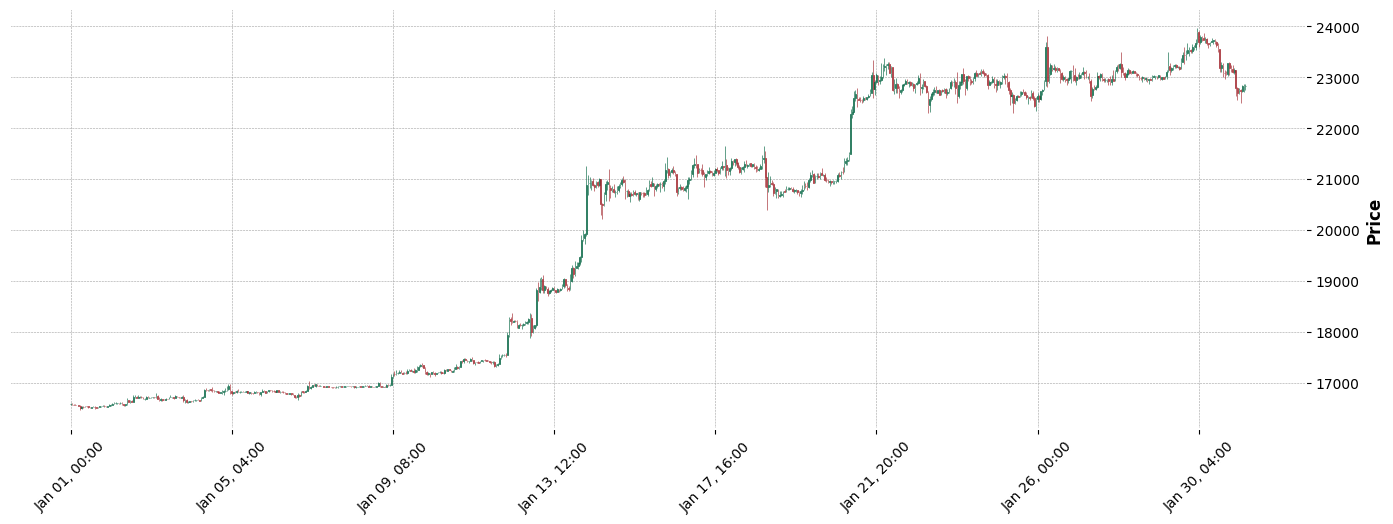

In [14]:
mpf.plot(dataCoin1.loc[endTime-timedelta(days=31):endTime], type='candle',style='charles', figsize=(18,6), tight_layout=False) 

In [ ]:
mpf.save

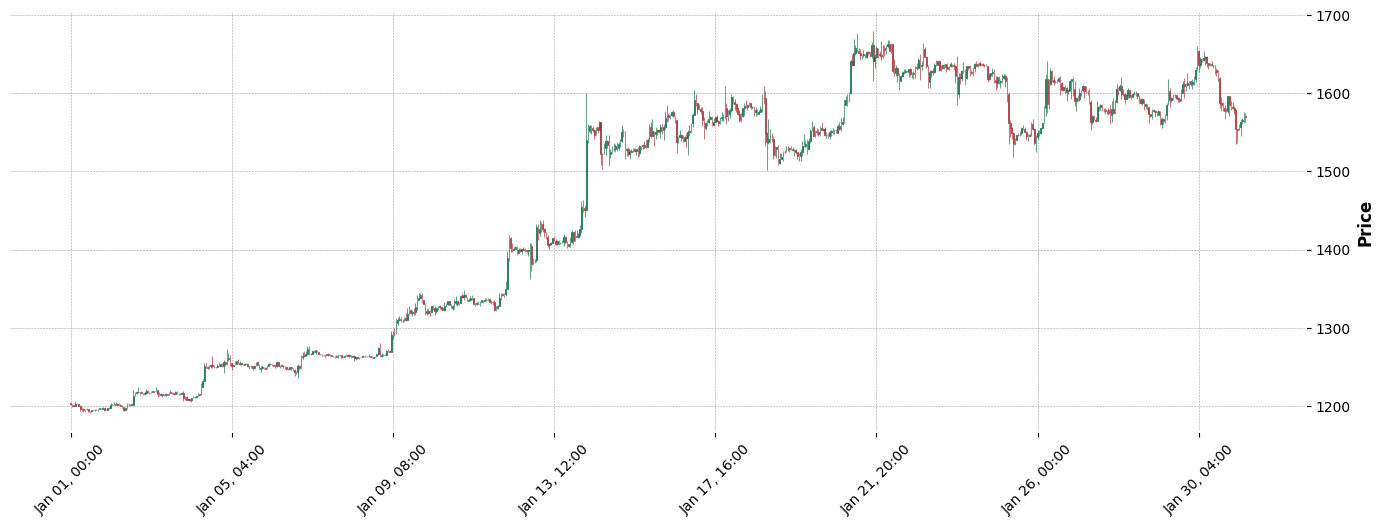

In [15]:
mpf.plot(dataCoin2.loc[endTime-timedelta(days=31):endTime], type='candle',style='charles', figsize=(18,6), tight_layout=False) 

In [29]:
def cal_pctChange(data, lastTime, periodList=[1, 2, 3, 4]):
    pctChangeDict = {}
    for period in periodList:
        pctChangeDict['Week'+str(period)] = str(round((data.loc[lastTime-timedelta(hours=(7*(period-1))*24)]/data.loc[lastTime-timedelta(hours=(7*period)*24)]-1)*100, 2))+'%'
    pctChangeDict['monthly'] = str(round((data.loc[lastTime]/data.loc[lastTime-timedelta(hours=(7*4)*24)]-1)*100, 2))+'%'
    pctChangeDf = pd.Series(pctChangeDict)
    return pctChangeDf

In [30]:
lastTime = dataCoin1.index[-1]
pctCoin1 = cal_pctChange(dataCoin1.close, lastTime)
pctCoin2 = cal_pctChange(dataCoin2.close, lastTime)

In [31]:
pctChangeDf = pd.DataFrame({
    'btc_pctChange': cal_pctChange(dataCoin1.close, lastTime),
    'eth_pctChange': cal_pctChange(dataCoin2.close, lastTime),
    
})

In [33]:
pctChangeDfT = pctChangeDf.T

In [34]:
pctChangeDfT.to_excel('PricePctChange.xlsx')

In [37]:
pctChangeDfT

,Week1,Week2,Week3,Week4,monthly
btc_pctChange,-1.12%,9.73%,22.37%,3.1%,36.89%
eth_pctChange,-4.15%,5.26%,17.47%,9.1%,29.31%
